In [1]:
%matplotlib inline


# Generalized Linear Model


## Logistic Regressions

Logistic regression is a important model to solve classification problem, which is expressed specifically as:
$$
\begin{aligned}
& P(y=1 \mid x)=\frac{1}{1+\exp \left(-x^T \beta\right)}, \\
& P(y=0 \mid x)=\frac{1}{1+\exp \left(x^T \beta\right)},
\end{aligned}
$$
where $\beta$ is an unknown parameter vector that to be estimated. Since we expect only a few explanatory variables contribute for predicting $y$, we assume $\beta$ is sparse vector with sparsity level $s$.

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{y_i x_i^T \beta-\log \left(1+\exp \left(x_i^T \beta\right)\right)\right\}, \text { s.t. }\|\beta\|_0 \leq s
$$

### Import necessary packages

In [2]:
import jax.numpy as jnp
import numpy as np
from scope import ScopeSolver
import numpy as np

### Generate the data

In [3]:
np.random.seed(0)
def data_generator(n, p, s, rho, random_state=None):
    """
    * $\beta^*_i$ ~ N(0, 1), $\forall i \in supp(\beta^*)$
    * $x = (x_1, \cdots, x_p)^T$, $x_{i+1}=\rho x_i+\sqrt{1-\rho^2}z_i$, where $x_1, z_i$ ~ N(0, 1)
    * $y\in\{0,1\}$, $P(y=0)=\frac{1}{1+\exp^{x^T\beta^*+c}}$
    """
    np.random.seed(random_state)
    # beta
    beta = np.zeros(p)
    true_support_set = np.random.choice(p, s, replace=False)
    beta[true_support_set] = np.random.uniform(1, 2, s)
    # X
    X = np.empty((n, p))
    X[:, 0] = np.random.normal(0, 1, n)
    for j in range(1, p):
        X[:, j] = rho * X[:, j - 1] + np.sqrt(1-rho**2) * np.random.normal(0, 1, n)
    # y
    xbeta = np.clip(X @ beta, -30, 30)
    p = 1 / (1 + np.exp(-xbeta))
    y = np.random.binomial(1, p)

    return X, y, beta, true_support_set

n, p, s, rho = 500, 500, 5, 0.0
X, y, true_params, true_support_set = data_generator(n, p, s, rho , 0)

### Define function to calculate negative log-likelihood of logistic regression

In [4]:
def logistic_loss(params):
    xbeta = jnp.clip(X @ params, -30, 30)
    return jnp.mean(jnp.log(1 + jnp.exp(xbeta)) - y * xbeta)

### Use scope to solve the sparse logistic regression problem

In [5]:
solver = ScopeSolver(p, s)
solver.solve(logistic_loss, jit=True)

print("True support set: ", np.sort(true_support_set))
print("Estimated support set: ", np.sort(solver.support_set))
#print("True parameters: ", true_params)
#print("True loss value: ", logistic_loss(true_params))
#print("Estimated parameters: ", solver.params)
print("Estimated loss value: ", logistic_loss(solver.params))

True support set:  [ 90 254 283 445 461]
Estimated support set:  [ 90 254 283 445 461]
Estimated loss value:  0.3428498


### More on the results

We can plot the sparse signal recovering from the noisy observations to visualize the results.

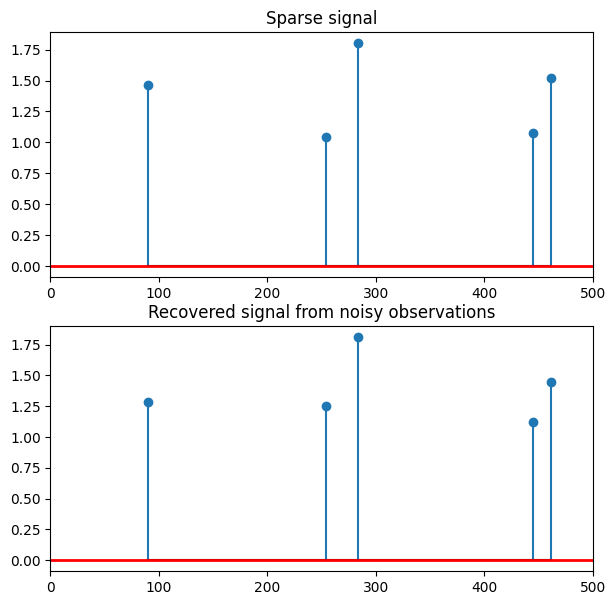

In [6]:
import matplotlib.pyplot as plt
(inx_true,) =  true_params.nonzero()
(inx_est,) =  solver.params.nonzero()

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(inx_true, true_params[inx_true], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(inx_est, solver.params[inx_est], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()

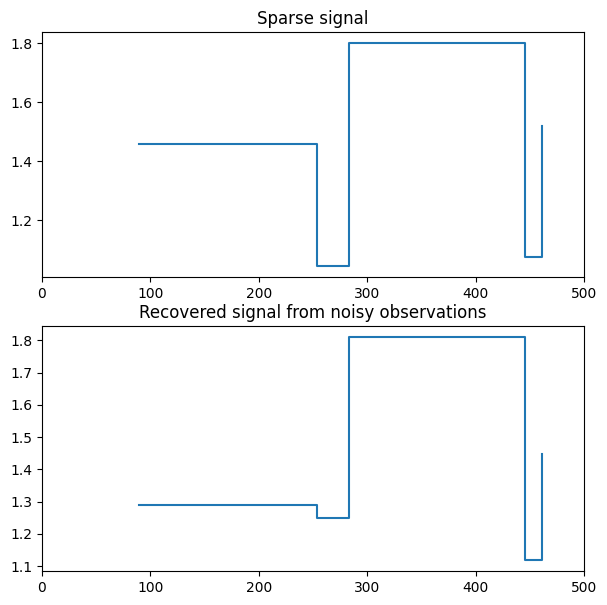

In [7]:
import matplotlib.pyplot as plt
(inx_true,) =  true_params.nonzero()
(inx_est,) =  solver.params.nonzero()

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.stem(inx_true, true_params[inx_true])
plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.stem(inx_est, solver.params[inx_est])
plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()